In [4]:
import numpy as np
import timeit
import sys
import pandas as pd
from typing import NamedTuple, List, Tuple
from IPython.display import display
from shapely.geometry import Point, Polygon
from shapely.geometry.polygon import Polygon as ShapelyPolygon

# MCTS code imports
sys.path.append("..")  # Adds higher directory to python modules path.
from main import MeasurementControlEnvironment
from utils import get_ellipse_scaling

In [5]:
class ObjectTuple(NamedTuple):
    object_type: str         # occlusion, obstacle, ooi
    shape: str               # circle, 4polygon
    mean: np.ndarray         # [x, y]
    ooi_id: int=None
    points: np.ndarray=None  # [[x1, y1], [x2, y2], [x3, y3], [x4, y4]]
    covariances: List[np.ndarray]=None
    radius: float=None

obj1 = ObjectTuple(object_type='occlusion',
                   shape='circle',
                   mean=np.array([50, 45]),
                   radius=5.0
)

obj2 = ObjectTuple(object_type='obstacle',
                   shape='4polygon',
                   mean=np.array([10, 10]),
                   points=np.array([[10, 10],[14, 10], [14, 14], [10, 14]])
)

obj3 = ObjectTuple(object_type='occlusion',
                   shape='circle',
                   mean=np.array([40, 40]),
                   radius=1.0
)

obj4 = ObjectTuple(object_type='occlusion',
                   shape='4polygon',
                   mean=np.array([30, 30]),
                   points=np.array([[30, 30],[34, 30], [34, 34], [30, 34]])
)

obj5 = ObjectTuple(object_type='ooi',
                   shape='4polygon',
                   mean=np.array([62, 62]),
                   ooi_id=0,
                   points=np.array([[60, 60],[64, 60], [64, 64], [60, 64]]),
                   covariances=[np.diag([3.5, 2.5]),
                                np.diag([3.5, 2.5]),
                                np.diag([3.5, 2.5]),
                                np.diag([3.5, 2.5])]
)


df = pd.DataFrame([obj1, obj2, obj3, obj4, obj5])
df.head()

,object_type,shape,mean,ooi_id,points,covariances,radius
0,occlusion,circle,"[50, 45]",NaN,None,None,5.0
1,obstacle,4polygon,"[10, 10]",NaN,"[[10, 10], [14, 10], [14, 14], [10, 14]]",None,NaN
2,occlusion,circle,"[40, 40]",NaN,None,None,1.0
3,occlusion,4polygon,"[30, 30]",NaN,"[[30, 30], [34, 30], [34, 34], [30, 34]]",None,NaN
4,ooi,4polygon,"[62, 62]",0.0,"[[60, 60], [64, 60], [64, 64], [60, 64]]","[[[3.5, 0.0], [0.0, 2.5]], [[3.5, 0.0], [0.0, ...",NaN


In [89]:
class ObjectManager:
    def __init__(self, num_obstacles: int, num_occlusion: int, num_oois: int, car_collision_radius: float,
                 car_sensor_range: float, car_max_bearing: float, df: pd.DataFrame=None, object_bounds:np.ndarray=np.array([15, 85]),
                 size_bounds: np.ndarray=np.array([1.0, 10.0]), init_covariance_diag: float=8, ui=None):
        # Random object generation parameters
        self.num_obstacles = num_obstacles
        self.num_occlusion = num_occlusion
        self.num_oois = num_oois
        self.object_bounds = object_bounds
        self.size_bounds = size_bounds
        self.init_covariance_diag = init_covariance_diag
        self.bounding_box_buffer = 5.0 # Buffer for the bounding box of the car sensor area to filter out objects
        self.object_min_spacing = 0.5
        
        # Car parameters and UI for drawing observations
        self.car_collision_radius = car_collision_radius
        self.car_sensor_range = car_sensor_range
        self.car_max_bearing = car_max_bearing
        self.ui = ui
        
        # Start with no objects if 'df' not set and raise an error if they are not generated
        self.df = df
        
    def reset(self, car_state):
        """
        This function generates obstacles, occlusions and OOIs and stores them in a dataframe of the class.
        It does this by generating objects and checking if they overlap with the car or other objects.
        param car_state: The state of the car [x, y, theta] used for overlap checking
        """
        # Initialize empty lists for each object type
        obstacles = []
        occlusions = []
        oois = []
        
        # Add the car as an obstacle so that objects don't spawn inside it but we don't add it to the dataframe
        car_list = [ObjectTuple(object_type='obstacle', shape='circle', mean=car_state[0:2], radius=self.car_collision_radius)]
        
        def is_overlapping(new_obj, existing_objs):
            if existing_objs is None:
                return False
            
            for obj in existing_objs:
                dist = np.linalg.norm(new_obj.mean - obj.mean)
                if dist < (new_obj.radius + obj.radius + self.object_min_spacing):
                    return True
            return False
        
        # Generate obstacles
        for _ in range(self.num_obstacles):
            while True:
                mean = np.random.uniform(self.object_bounds[0], self.object_bounds[1], size=2)
                radius = np.random.uniform(self.size_bounds[0], self.size_bounds[1])
                new_obj = ObjectTuple(object_type='obstacle', shape='circle', mean=mean, radius=radius)
                if not is_overlapping(new_obj, car_list + obstacles + occlusions + oois):
                    obstacles.append(new_obj)
                    break
        
        # Generate occlusions
        for _ in range(self.num_occlusion):
            while True:
                mean = np.random.uniform(self.object_bounds[0], self.object_bounds[1], size=2)
                radius = np.random.uniform(self.size_bounds[0], self.size_bounds[1])
                new_obj = ObjectTuple(object_type='occlusion', shape='circle', mean=mean, radius=radius)
                if not is_overlapping(new_obj, car_list + obstacles + occlusions + oois):
                    occlusions.append(new_obj)
                    break
        
        # Generate OOIs
        for i in range(self.num_oois):
            while True:
                mean = np.random.uniform(self.object_bounds[0], self.object_bounds[1], size=2)
                length_width = np.random.uniform(self.size_bounds[0], self.size_bounds[1], size=2)
                max_radius = np.linalg.norm(length_width) / 2
                points = np.array([mean + np.array([-length_width[0]/2, -length_width[1]/2]),
                                mean + np.array([length_width[0]/2, -length_width[1]/2]),
                                mean + np.array([length_width[0]/2, length_width[1]/2]),
                                mean + np.array([-length_width[0]/2, length_width[1]/2])])
                covariances = [np.diag([self.init_covariance_diag, self.init_covariance_diag]) for _ in range(4)]
                new_obj = ObjectTuple(object_type='ooi', shape='4polygon', ooi_id=i, mean=mean, points=points, covariances=covariances, radius=max_radius)
                if not is_overlapping(new_obj, car_list + obstacles + occlusions + oois):
                    oois.append(new_obj)
                    break
        
        self.df = pd.DataFrame(obstacles + occlusions + oois)
        
    def draw_objects(self, car_state):
        if self.df is None:
            raise ValueError('Objects have not been generated yet')
        
        # Iterate through the rows of the dataframe
        for tuple in self.df.itertuples(index=True, name='ObjectTuple'):
            # Draw the car collision radius
            self.ui.draw_circle(car_state[0:2], self.car_collision_radius, color='r', facecolor='none', alpha=0.1)
            
            if tuple.object_type == 'obstacle':
                if tuple.shape == '4polygon':
                    # Draw the polygon
                    self.ui.draw_polygon(tuple.points, linestyle='-', color='r', facecolor='r', alpha=0.2)
                elif tuple.shape == 'circle':
                    # Draw the circle
                    self.ui.draw_circle(tuple.mean, tuple.radius, color='r', facecolor='r', alpha=0.2)
                else:
                    raise ValueError('Unknown shape')
            elif tuple.object_type == 'occlusion':
                if tuple.shape == '4polygon':
                    # Draw the polygon
                    self.ui.draw_polygon(tuple.points, linestyle='-', color='y', facecolor='y', alpha=0.3)
                elif tuple.shape == 'circle':
                    # Draw the circle
                    self.ui.draw_circle(tuple.mean, tuple.radius, color='y', facecolor='y', alpha=0.3)
                else:
                    raise ValueError('Unknown shape')
                
            elif tuple.object_type == 'ooi':
                if tuple.shape != '4polygon':
                    raise ValueError('OOIs must be 4polygons')
                # Draw the polygon
                self.ui.draw_polygon(tuple.points, color='b', facecolor='None', linestyle='--', alpha=1.0)
                
                # Draw the points
                for point in tuple.points:
                    self.ui.draw_point(point, color='cyan')
                    
                # Draw the covariance ellipses
                for pt, cov in zip(tuple.points, tuple.covariances):
                    scalings, angle = get_ellipse_scaling(cov)
                    self.ui.draw_ellipse(pt, scalings[0], scalings[1], angle=angle, color='b', alpha=0.25, linestyle='-')
                    
    def collision_check(self, car_state, draw=True):
        if self.df is None:
            raise ValueError('Objects have not been generated yet')
        
        # First filter out any objects whose mean is farther than the car collision radius plus a buffer
        mean_in_range = np.linalg.norm(np.vstack(self.df['mean']) - car_state[0:2], axis=1) < self.car_collision_radius + 10.0
        df_close = self.df[mean_in_range]
        
        # If there is none close, return the empty dataframe
        if df_close.empty:
            return df_close
        
        # Initialize an empty list for offending indices
        offending_indices = []
        
        # Get car position
        car_pos = car_state[0:2]
        
        # First check the circle objects
        df_circle = df_close[df_close['shape'] == 'circle']
        if not df_circle.empty:
            # Find the distance between the car and the circle centers
            circle_centers = np.vstack(df_circle['mean'].values)
            distances = np.linalg.norm(circle_centers - car_pos, axis=1)
            
            # Check if the distance is less than both radii combined
            offending_obstacles = distances < (self.car_collision_radius + df_circle['radius'].values)
            
            # Add offending circle obstacle indices to the list
            offending_indices.extend(df_circle[offending_obstacles].index)
        
        # Now check the polygon objects
        df_poly = self.df[self.df['shape'] == '4polygon']
        if not df_poly.empty:
            # Get the distances of all polygon points to the car
            poly_points = np.vstack(df_poly['points'].values)
            distances = np.linalg.norm(poly_points - car_pos, axis=1)
            
            # Offending points are those that are less than the car collision radius
            offending_poly_points = distances < self.car_collision_radius # Get boolean array of each point
            offending_poly_points_reshaped = offending_poly_points.reshape(-1, 4) # Convert to a row for each object and 4 bools per object
            offending_poly_obstacles = np.logical_or.reduce(offending_poly_points_reshaped, axis=1) # Find what rows have any offending points
        
            # Add offending polygon obstacle indices to the list
            offending_indices.extend(df_poly[offending_poly_obstacles].index)
        
        # Return the rows of the input dataframe that are offending
        offending_rows = self.df.loc[offending_indices]
        
        # If draw is enabled then fill in the car collision radius to show it is in a collision
        if draw:
            if not offending_rows.empty:
                self.ui.draw_circle(car_state[0:2], self.car_collision_radius, color='r', facecolor='orange', alpha=0.3)
            
        return offending_rows
    
    def get_observations(self, car_state, draw=True):
        """
        This is a fast implementation for getting corner observations while considering occlusions.
        It first filters out objects by mean that are outside the sensor range or bearing with a buffer and exits if there are no OOIs in the list.
        Then it sorts the objects by range and iterates through them in order of increasing range.
        The widest part of the object is found and the bearing interval of the object is masked off.
        Finally OOI points are checked to see if they are occluded by the object itself or any other occlusions and observations are returned.
        """
        if self.df is None:
            raise ValueError('Objects have not been generated yet')
    
        # Create a rectangular bounding box for the car sensor range to filter out by mean
        # Start by creating vectors from the car pointing in the direction of the car's heading and +/- max bearing
        farthest_range_vectors = np.array([[np.cos(car_state[3]),
                                            np.sin(car_state[3])],
                                           [np.cos(car_state[3] + self.car_max_bearing),
                                            np.sin(car_state[3] + self.car_max_bearing)],
                                           [np.cos(car_state[3] - self.car_max_bearing),
                                            np.sin(car_state[3] - self.car_max_bearing)]])
        
        # Normalize and multiply by the sensor range to get points at the farthest range
        norms = np.linalg.norm(farthest_range_vectors, axis=1).reshape(-1, 1)
        farthest_range_vectors = farthest_range_vectors / norms * self.car_sensor_range
        
        # Stack the car position with the farthest points to get the 4 corners of the sensor range
        outer_points = np.vstack((car_state[0:2], farthest_range_vectors + car_state[0:2]))
        x_min, x_max = np.min(outer_points[:,0]) - self.bounding_box_buffer, np.max(outer_points[:,0]) + self.bounding_box_buffer
        y_min, y_max = np.min(outer_points[:,1]) - self.bounding_box_buffer, np.max(outer_points[:,1]) + self.bounding_box_buffer
        
        # if draw:
        #     # Draw the bounding box
        #     bounding_box_points = np.array([[x_min, y_min], [x_max, y_min], [x_max, y_max], [x_min, y_max]])
        #     self.ui.draw_polygon(bounding_box_points, color='g', facecolor='none', alpha=0.4)
        
        # Go ahead and remove non-occlusions (obstacles) from the dataframe to reduce computation
        occlusion_df = self.df[(self.df['object_type'] == 'occlusion') | (self.df['object_type'] == 'ooi')]
        
        # Now use the maxes and mins with buffer to see if the object means are in the bounding box
        obj_means = np.vstack(occlusion_df['mean'])
        obj_mean_in_bounding_box = (x_min < obj_means[:,0]) & (obj_means[:,0] < x_max) & (y_min < obj_means[:,1]) & (obj_means[:,1] < y_max)
        
        # This gives us the objects that are in the bounding box
        df_in_bounding_box = occlusion_df[obj_mean_in_bounding_box].copy() # Make a copy to avoid SettingWithCopyWarning
        
        # If there is no OOIs in range, which we are doing the occlusion check for, return an empty dictionary of observations
        df_ooi = df_in_bounding_box[df_in_bounding_box['object_type'] == 'ooi']
        if df_ooi.empty:
            return {}
        
        # Now create the range column to later sort the observable objects by minimum range
        car_to_obj_means = np.vstack(df_in_bounding_box['mean']) - car_state[0:2]
        ranges = np.linalg.norm(car_to_obj_means, axis=1)
        df_in_bounding_box.loc[:, 'range'] = ranges
        
        # Remove the radius from the range for circles, to better sort by range for occlusions
        df_in_bounding_box.loc[df_in_bounding_box['shape'] == 'circle', 'range'] -= df_in_bounding_box['radius']
        df_range_sorted = df_in_bounding_box.sort_values(by='range')
        
        # Now iterate through objects in order of increasing range
        occluded_bearings = np.empty((0,2)) # Maintained to check if an object is occluded
        observations = {} # Maintained to store the observations of the OOIs {ooi_id: [idx0, ..., idxn]}
        for tuple in df_range_sorted.itertuples(index=True, name='ObjectTuple'):
            if tuple.object_type == 'ooi':
                # Get the points, bearings and ranges of the points
                points = tuple.points
                bearings = np.arctan2(points[:,1] - car_state[1], points[:,0] - car_state[0]) - car_state[3]
                ranges = np.linalg.norm(points - car_state[0:2], axis=1)
                
                # Sort by ranges and get the closest point and it's two neighbors
                sorted_indices = np.argsort(ranges)
                closest_idx = sorted_indices[0]
                lower_neighbor_idx = (sorted_indices[0] - 1) % 4
                higher_neighbor_idx = (sorted_indices[0] + 1) % 4
                
                # Pull out the bearing intervals which are occluded by the object itself and place in one array
                lower_to_closest_interval = np.sort(np.array([bearings[lower_neighbor_idx], bearings[closest_idx]]))
                closest_to_higher_interval = np.sort(np.array([bearings[closest_idx], bearings[higher_neighbor_idx]]))
                ooi_occluded_bearings = np.vstack((lower_to_closest_interval, closest_to_higher_interval))
                
                # Initialize a boolean array tracking whether a point is occluded by the OOI itself
                is_point_not_ooi_occluded = np.zeros(4, dtype=bool)
                for i, bearing in enumerate(bearings):
                    is_point_not_ooi_occluded[i] = ~(np.any((ooi_occluded_bearings[:,0] < bearing) & (bearing < ooi_occluded_bearings[:,1])))
                
                # Take the indices of the non-occluded points and sort them by increasing index
                non_ooi_occluded_indices = np.arange(4)[is_point_not_ooi_occluded]
                
                # Check for each bearing if it lies in between any intervals of occluded bearings and within sensor range and bearing
                non_occluded = np.zeros(non_ooi_occluded_indices.shape[0], dtype=bool)
                for i, bearing in enumerate(bearings[non_ooi_occluded_indices]):
                    # Not any ((vector of mins < bearing) and (bearing < vector of maxes))
                    non_object_occluded = ~(np.any((occluded_bearings[:,0] < bearing) & (bearing < occluded_bearings[:,1])))
                    
                    # Range must be less than sensor range and absolute bearing must be less than max bearing
                    visible_by_sensor = (ranges[i] < self.car_sensor_range) & (np.abs(bearing) < self.car_max_bearing)
                    
                    non_occluded[i] = non_object_occluded & visible_by_sensor
                

                # If there is any non-occluded points, store the observation
                if np.any(non_occluded):
                    # Store the observation of non-occluded points with key of ooi_id
                    observations[tuple.ooi_id] = non_ooi_occluded_indices[non_occluded]
                    
                # Add this OOI as an occlusion for future iterations
                occluded_bearings = np.vstack((occluded_bearings, np.array([np.min(bearings), np.max(bearings)]))) # Find the min and max bearing of the object
                
            # If the object is a polygon occlusion, add the max and min bearing interval using the points
            elif (tuple.object_type == 'occlusion') & (tuple.shape == '4polygon'):
                # Find the bearings of the points, take the min and max and add to the occluded bearing intervals
                bearings = np.arctan2(tuple.points[:,1] - car_state[1], tuple.points[:,0] - car_state[0]) - car_state[3] # Find the bearing of each point
                occluded_bearings = np.vstack((occluded_bearings, np.array([np.min(bearings), np.max(bearings)]))) # Find the min and max bearing of the object
            
            # If the object is a circle occlusion, add the bearing interval using the mean and radius
            elif (tuple.object_type == 'occlusion') & (tuple.shape == 'circle'):
                # Find the bearing of the center point, find the angle to the edge and add to the occluded bearing intervals
                bearing = np.arctan2(tuple.mean[1] - car_state[1], tuple.mean[0] - car_state[0]) - car_state[3]
                mean_to_edge_angle = np.arcsin(tuple.radius / (tuple.range + tuple.radius)) # Adding back radius which was removed before for sorting
                occluded_bearings = np.vstack((occluded_bearings, np.array([bearing - mean_to_edge_angle, bearing + mean_to_edge_angle])))
        
        if draw:
            # Draw the observations
            for ooi_id, indices in observations.items():
                points = df_ooi[df_ooi['ooi_id'] == ooi_id]['points'].values[0][indices]
                
                # Draw the points
                for point in points:
                    self.ui.draw_arrow(car_state[0:2], point, color='g', alpha=0.1)
                    self.ui.draw_circle(point, 0.5, color='g', facecolor='none', alpha=0.7)
                    
        return observations

In [60]:
env = MeasurementControlEnvironment()
object_manager = ObjectManager(num_obstacles=4, num_occlusion=4, num_oois=3, car_collision_radius=3.0,
                               car_sensor_range=40.0, car_max_bearing=np.radians(60), ui=env.ui)

Toy Measurement Control Initialized


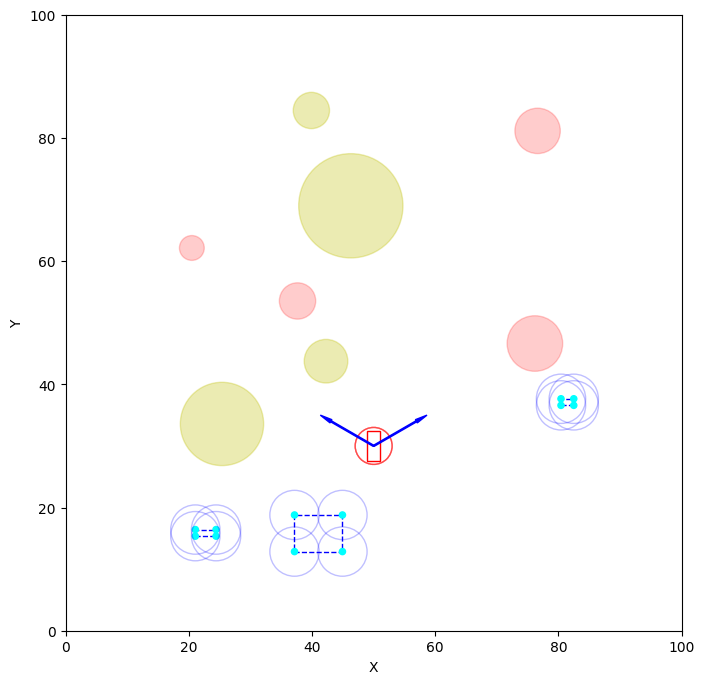

In [90]:
object_manager = ObjectManager(df=object_manager.df, num_obstacles=4, num_occlusion=4, num_oois=3, car_collision_radius=3.0,
                                 car_sensor_range=40.0, car_max_bearing=np.radians(60), ui=env.ui)
# display(object_manager.df.head(20))
car_state = np.array([50, 30, 0, np.radians(90), 0, 0])
object_manager.reset(car_state=car_state)
object_manager.draw_objects(car_state=car_state)
env.car.draw_state(car_state)
df_offending = object_manager.collision_check(car_state=car_state)
observations = object_manager.get_observations(car_state=car_state)
env.ui.plot()
# print(f'Observations: {observations}')